In [8]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
import os
import cv2
import math
import tensorflow as tf

# Utility scripts to add abstraction to the models
import car_extractor
import yaw_pred
import camera_utils
import pos_pred

## Load Paths of the dataset used

In [9]:
content_dir = os.path.abspath('H:\Data_Science_Masters\\third_sem_documents\Learning For Images\project\main')

BASE_DIR_IMAGES = os.path.abspath(content_dir)+'/{}_images/'
BASE_DIR_MASKS = os.path.abspath(content_dir)+'/{}_masks/'
DIR_TRAIN_CSV = os.path.abspath(content_dir)+'/train.csv'
BASE_DIR_IMAGES

'H:\\Data_Science_Masters\\third_sem_documents\\Learning For Images\\project\\main/{}_images/'

## Load Pre-trained Models
We load the three models with:

In [10]:
yolo = car_extractor.get_model('trained_models/yolo.h5') # Car detection Model
yaw_model = yaw_pred.get_model('trained_models/yaw_new.h5') # Yaw prediction Model
model_pos = pos_pred.load_model('trained_models/pos_predictor.joblib') ## 3d position prediction model

## Utility Functions
Some utility functions to work with the data and display images

In [11]:
def image_names(partition='train'):
    print(BASE_DIR_IMAGES.format(partition))
    return os.listdir(BASE_DIR_IMAGES.format(partition))

def load_img(img_name, partition='train'):
    image = Image.open((BASE_DIR_IMAGES + '\\{}').format(partition, img_name))
    image_mask = None
    try:
        image_mask = Image.open((BASE_DIR_MASKS + '{}').format(partition, img_name))
    except FileNotFoundError:
        pass
    return image, image_mask

def get_pred_string(img_name):
    name = img_name.split('.')[0]
    coords_str = TRAIN_DF[TRAIN_DF['ImageId'] == name]['PredictionString'].iloc[0]
    return coords_str
    
def add_mask(img, mask):
    mask_array = np.array(mask)
    masked = np.array(img)
    masked[mask_array > 0] = 255
    return Image.fromarray(masked)

def parse_pred_string(string):
    """ Converts an string to a list of arrays with the positions of the cars. """
    cars = []
    split_string = string.split()
    for i in range(0, len(split_string), 7):
        arr_i = split_string[i:i+7]
        arr_i = [float(i) for i in arr_i]
        arr_i[0] = int(arr_i[0])
        cars.append(arr_i)
    return cars

def get_rot_matrix(euler_rot):
    yaw, pitch, roll = euler_rot
    
    yaw, pitch, roll = -yaw, -pitch, -roll

    # The data reference edges seem to be rotated. This matrices work.
    # https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car#kln-87
    
    rot_x = np.array([
                        [1,     0,              0         ],
                        [0, math.cos(yaw), -math.sin(yaw) ],
                        [0, math.sin(yaw), math.cos(yaw)  ]
                    ])
         
    rot_y = np.array([
                        [math.cos(pitch),  0,      math.sin(pitch) ],
                        [0,                1,      0               ],
                        [-math.sin(pitch), 0,      math.cos(pitch) ]
                    ])
                 
    rot_z = np.array([
                        [math.cos(roll), -math.sin(roll), 0],
                        [math.sin(roll),  math.cos(roll), 0],
                        [0,               0,              1]
                    ])
                     
                     
    rotation_matrix = np.dot(rot_x, np.dot(rot_y, rot_z))
 
    return rotation_matrix

def get_point_arround(world_point, rotation_angles, offsets=[[0,0,2]]):
    """Adds points arround the center (world point) and rotates them to match the 
    car rotation (taking as origin world point).
    This can be used to calculate several points arround a vehicle (draw 3D bounding boxes, etc). 
    
    Params:
    world_point: numpy array [3] (x,y,z) of the car in the world.
    rotation_angles: numpy array [3]. (yaw, pitch, roll) in radians.
    offsets: List[List[3]] Points arround the world point (by default it is only one point 2 units ahead of the vehicle center).
    
    Returns:
        Numpy array with all the point(s) rotated acordingly to the center point.
    """
    rot_from_origin = np.eye(4)
    origin = world_point
    rot_from_origin[:3, 3] = origin
    rot_from_origin[:3, :3] = get_rot_matrix(rotation_angles)
    rot_from_origin = rot_from_origin[:3, :]
    
    points = np.ones((len(offsets), 4))
    points[:,:3] = np.array(offsets)
    points = points.T
            
    point = np.dot(rot_from_origin, points).T
    return point
    

    
def plot_car_directions(image, coords, as_matrix=False):
    """ Plots a point on each car and a green arrow pointing towards its direction (yaw pitch roll) 
    
    Parameters:
    image: PIL Image
    coords: Coordinate array of the cars (this is the parsed string from the dataset).
    """
    im = np.array(image)
    
    world_coords = [x[-3:] for x in coords]
    courses = [x[1:4] for x in coords]

    transformed = camera_utils.to_cam_xy(world_coords)

    points_directions = [get_point_arround(center_point, rotaton) for center_point, rotaton in zip(world_coords, courses)]
    transformed_dests = np.array([camera_utils.to_cam_xy(points) for points in points_directions])
    
    # Car position (in 2D)
    x0 = transformed[:,0]
    y0 = transformed[:,1]

    # Movement vector (yaw, pitch, roll) in 2D
    x1 = transformed_dests[:,:,0].flatten()
    y1 = transformed_dests[:,:,1].flatten()
    
    if as_matrix:
        points = np.zeros((image.size[1], image.size[0], 3), dtype='uint8')
        for i in range(len(world_coords)):
            points[int(x0[i]),int(y0[i]), : ] = 255
            points[int(x1[i]),int(y1[i]), : ] = 122
            return points
    ## restrict it to 255x122?
    for i in range(len(world_coords)):
        im = cv2.arrowedLine(im, (int(x0[i]),int(y0[i])), (int(x1[i]),int(y1[i])), (0,255,0), 3, tipLength=0.06)
        im = cv2.circle(im, (int(x0[i]),int(y0[i])), 10, (255,0,0), -1)
    return Image.fromarray(im)

def draw_car_boxes(image, car_boxes):
    im_arr = np.array(image)
    for i in range(len(car_boxes)):
        point1 = (int(3384 * car_boxes[i][0]), int(2710 * car_boxes[i][1]))
        point2 = (int(3384 * car_boxes[i][2]), int(2710 * car_boxes[i][3]))

        cv2.rectangle(im_arr, point1, point2, (255,0,0), 5)
## why 3384 and 2710
    return Image.fromarray(im_arr)

TRAIN_IMAGES = image_names('train')
TRAIN_DF = pd.read_csv(DIR_TRAIN_CSV)

TEST_IMAGES = image_names('test')

H:\Data_Science_Masters\third_sem_documents\Learning For Images\project\main/train_images/
H:\Data_Science_Masters\third_sem_documents\Learning For Images\project\main/test_images/


This function runs the pipeline of the three models on a given array of images

In [12]:
def pipeline_pred(images):
    """ Takes an array of images, runs the full pipeline (3 models) and returns a formated prediction array (as the requested one)"""
    CAR_TYPE = -1
    
    world_coords = []
    
    boxes = car_extractor.find_cars(images, yolo)
    
    for boxi, imi in zip(boxes, images):
        coords = [(camera_utils.IMAGE_WIDTH*((x[2]-x[0])/2 + x[0]), camera_utils.IMAGE_HEIGHT*((x[3]-x[1])/2 + x[1])) for x in boxi]
        boxes_widths= [((x[2]-x[0])/2, (x[3]-x[1])/2 ) for x in boxi]
        ray_angles = [camera_utils.get_ray_angle(c[0]) for c in coords]
    
        car_imgs = car_extractor.extract_car_images(imi, boxi)
        car_imgs = [np.array(im) for im in car_imgs]
    
        yaws = yaw_pred.predict_yaw(car_imgs, ray_angles, yaw_model, return_confidences=True)
        wp = pos_pred.predict(coords, boxes_widths, model_pos)
    
        pred_pos_string = [[CAR_TYPE, 0.15, y, 0, *w] for (y, w) in zip(yaws[0], wp)]
        
        world_coords.append(pred_pos_string)
    
    return world_coords

### An example

In [13]:
test_image_name = TRAIN_IMAGES[1]

print(test_image_name)

image, image_mask = load_img(test_image_name) # no usage of image masks

res = pipeline_pred([image])

orig_coords_str = parse_pred_string(get_pred_string(test_image_name))

ID_001d6829a.jpg


In [11]:
find_car_return = car_extractor.find_cars([image], yolo)
print('Total cars found:' ,len(find_car_return[0]))

Total cars found: 8


### Plot Detected Cars

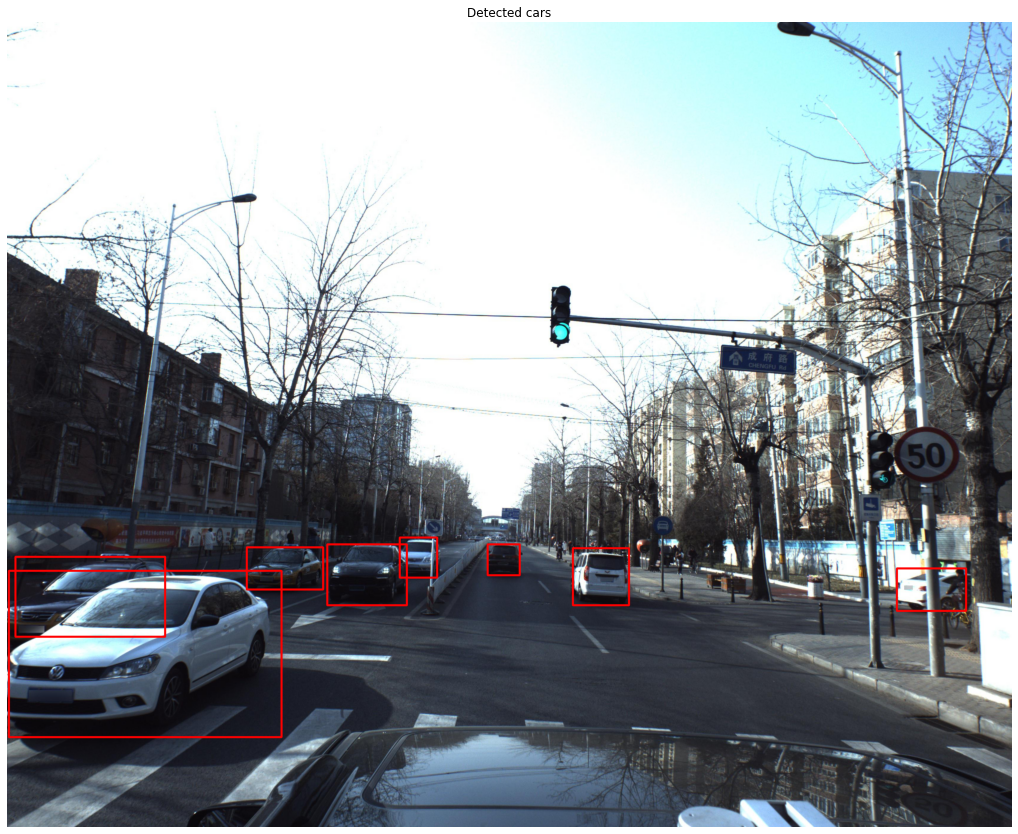

In [12]:
# Get and plot car boxes
boxes = car_extractor.find_cars([image], yolo)
im_boxes = draw_car_boxes(image, boxes[0])

fig, ax = plt.subplots(figsize=(18,26))
ax.imshow(im_boxes)
ax.set_title('Detected cars')
ax.axis('off');

### Plot Car Prediction 

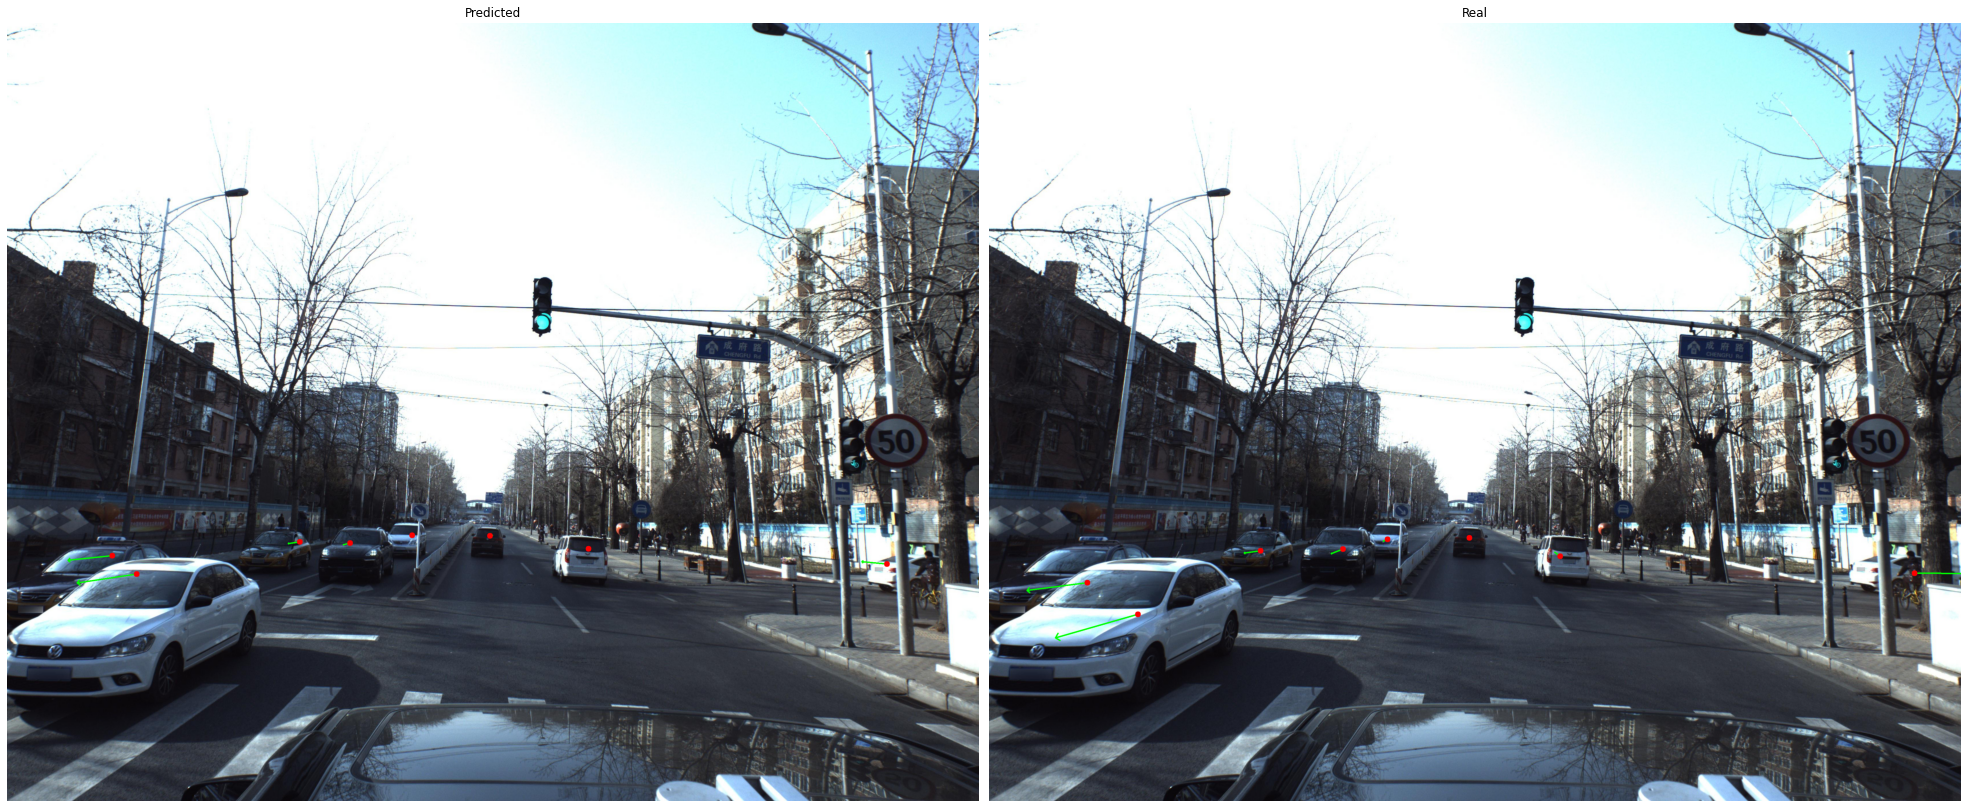

In [13]:
im_pred = plot_car_directions(image, res[0])
im_actual = plot_car_directions(image, orig_coords_str)


fig, ax = plt.subplots(1,2, figsize=(35,40))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
ax[0].imshow(im_pred)
ax[1].imshow(im_actual)


ax[0].set_title('Predicted')
ax[1].set_title('Real')
ax[0].axis('off')
ax[1].axis('off');

## Let's test it on the test set

In [33]:
image, image_mask = load_img(TEST_IMAGES[580], partition='test')
res = pipeline_pred([image])

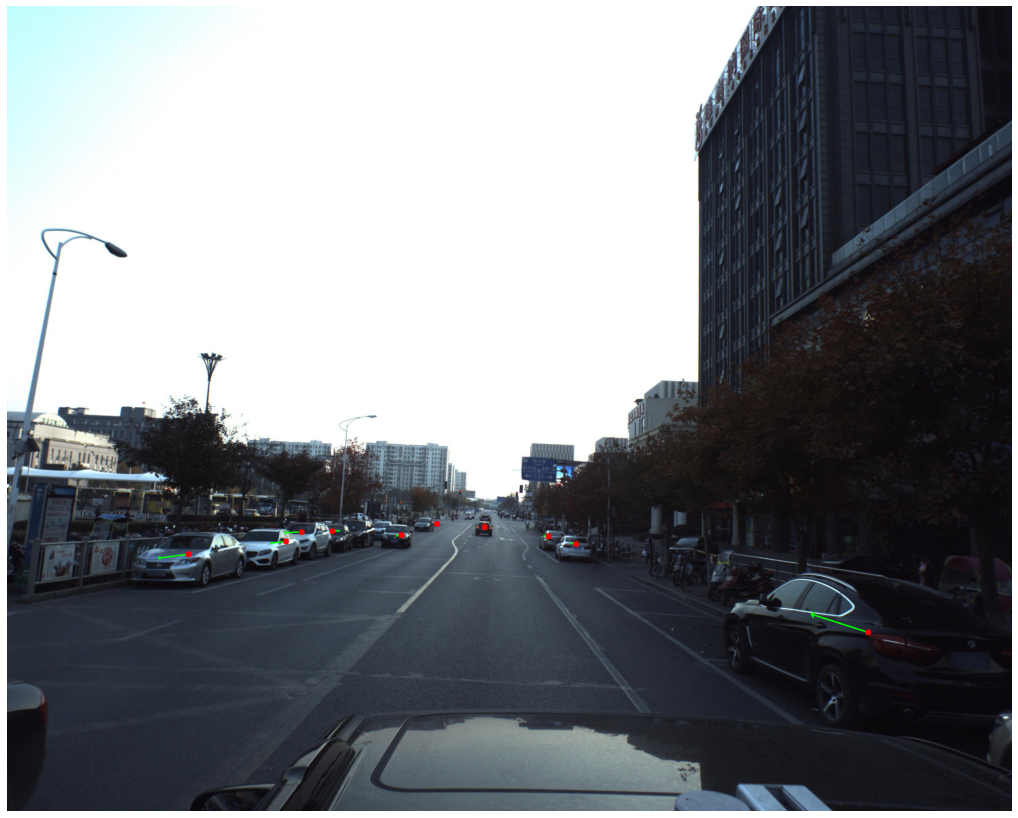

In [34]:
im_pred = plot_car_directions(image, res[0])

fig, ax = plt.subplots(figsize=(18,26))
ax.imshow(im_pred)
ax.axis('off');